### Imports

In [40]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2
from torchviz import make_dot
import pandas as pd

from notebooks.utils import display_render, pad_to_match_aspect, enforce_homogeneous_transform, enforce_homogeneous_transform_1, decompose_homogeneous_matrix, assemble_homogeneous_matrix, decompose_homogeneous_matrix_quaternion, quaternion_to_rotation_matrix, assemble_homogeneous_matrix_quaternion, enforce_joint_limit, optimization, optimization_w2v, optimization_quat, plot_loss, count_files, make_video


### Functions

### Initialization

In [41]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

In [42]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/p_short_exp_2', bg_color=[0, 0, 0])

# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/p_short_exp_2
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path


/home/iulian/chole_ws/src/drrobot/scene/gaussian_model.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrs = torch.load(os.path.join(os.path.dirname(path), 'lrs.pth'))

In [63]:
## ------ Configure Camera Parameters ------ ##
example_camera = sample_cameras[0]

## Customize camera parameters
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.1
cam.azimuth = -20.0
cam.elevation = -20
cam.lookat = (0,0,-0.4)
extrinsic = compute_camera_extrinsic_matrix(cam)
w2v = getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)
w2v_tensor = torch.tensor(getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)).transpose(0, 1).to(example_camera.data_device)
print(w2v)

## rotate the view
theta = -np.pi / 2  # 90 degrees in radians
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])

R = w2v[:3, :3]
t = w2v[:3, 3]

# Apply translation
t[1] = -0.5

# Apply the rotation
R_rotated = R_z @ R  # Rotate the original rotation matrix
t_rotated = R_z @ t  # Rotate the translation vector

# Combine back into a transformation matrix
T_rotated = np.eye(4)
T_rotated[:3, :3] = R_rotated
T_rotated[:3, 3] = t_rotated

T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)

example_camera.world_view_transform = T_rotated_torch
print(example_camera.world_view_transform)


[[-3.4202015e-01 -9.3969262e-01  2.9536866e-17  7.3842165e-18]
 [-3.2139382e-01  1.1697778e-01 -9.3969262e-01 -3.7587705e-01]
 [ 8.8302225e-01 -3.2139382e-01 -3.4202015e-01 -3.6808059e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -8.7076e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.8000e-17, -3.6808e-02,  1.0000e+00]])


['pitch', 'right_jaw', 'passive_1', 'left_jaw', 'passive_2']


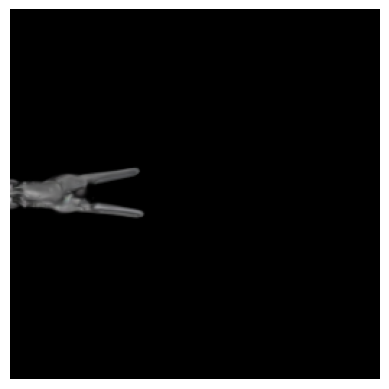

w2v: tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -8.7076e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.8000e-17, -3.6808e-02,  1.0000e+00]],
       requires_grad=True)
Sum of joint gradients: tensor(1192.3070)
Sum of camera gradients: tensor(291122.1250)


In [75]:
## ------ Render Init Gaussian ------ ##
n = len(kinematic_chain.get_joint_parameter_names())  
print(kinematic_chain.get_joint_parameter_names())  
home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
# home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
example_camera.joint_pose = torch.tensor(home_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)
result = render(example_camera, gaussians, background_color)

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
frame = mask  # Use the mask directly without clamping or thresholding

# Display the mask (optional, normalized for visualization)
display_render(torch.clamp(mask, 0, 1))

print("w2v:", example_camera.world_view_transform)
frame.sum().backward()
print('Sum of joint gradients:', example_camera.joint_pose.grad.sum())
print('Sum of camera gradients:', example_camera.world_view_transform.grad.sum())

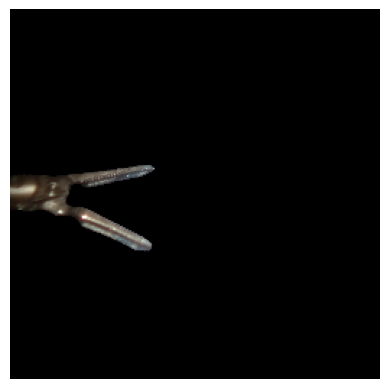

Reference image shape: torch.Size([3, 256, 256])
844.3558959960938


In [45]:
## ------ Display Reference Image ------ ##
original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/000000.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/mask_2.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/segmented_tool_8_0.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_77/1_grabbing_gallbladder/20240907-090634-569257/left_img_dir/frame000017_left.jpg"  # Path to your reference image

## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')

## crop the image to be square
# reference_image = np.array(reference_image)[:540, :540]
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = pad_to_match_aspect(reference_image, 1.0)

reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)

plt.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("Reference image shape:", reference_image.shape)  # Expected: [3, H, W]

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
normalization_factor = torch.sum(reference_image ** 2).item()  # Sum of squared pixel values
print(normalization_factor)

### Optimization

In [46]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().to("cuda").requires_grad_(True) # Initial camera transform
print(joint_pose_result)
print(world_view_transform_result)
# Define different learning rates
# joint_pose_lr = 2e-4
# world_transform_lr = 1e-4

joint_pose_lr = 1e-3
rotation_lr = 1e-4
translation_lr = 1e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# quat, translation = decompose_homogeneous_matrix_quaternion(example_camera.world_view_transform.clone().detach().cpu())
# quat = torch.nn.Parameter(quat, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": quat, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
num_iterations = 500

loss_fn = torch.nn.MSELoss()
video = []


tensor([ 0.0000,  0.1250,  0.2220, -0.2030,  0.2570], device='cuda:0',
       requires_grad=True)
tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -8.7076e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.8000e-17, -3.6808e-02,  1.0000e+00]], device='cuda:0',
       requires_grad=True)


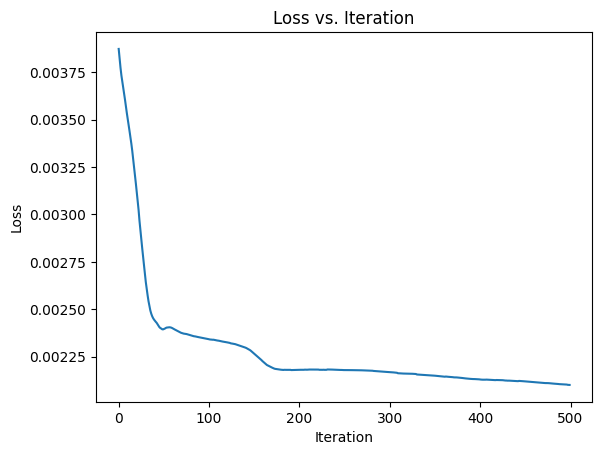

Final joint pose: tensor([ 0.0481,  0.1917,  0.1478, -0.1193,  0.2258], device='cuda:0',
       requires_grad=True)
Final camera transform: tensor([[-0.3287,  0.3944,  0.8582,  0.0000],
        [ 0.1310,  0.9189, -0.3721,  0.0000],
        [-0.9353, -0.0099, -0.3537,  0.0000],
        [-0.4984, -0.0050, -0.0462,  1.0000]], device='cuda:0',
       requires_grad=True)


In [47]:

# Optimization loop
video, joint_pose_result, world_view_transform_result= optimization_w2v(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations, plot=True)
# video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization_quat(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)

# Final results
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


MoviePy - Building file pose_est_init.gif with imageio.


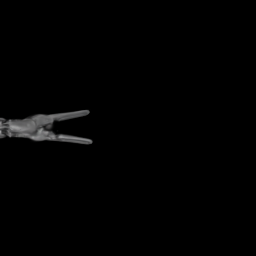

In [48]:
## ------ Save the video ------ ##
make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


(-0.5, 255.5, 255.5, -0.5)

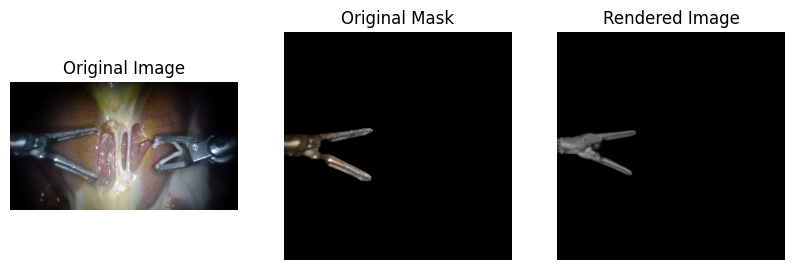

In [49]:
## ------ Compare the final rendered image and the reference image------ ##

final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)

# display_render(final_render)
padded_rendered_image = pad_to_match_aspect(final_render, target_aspect_ratio)
## subplot to show the original image and the rendered image
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original Image")
ax.imshow(original_image)
ax.axis('off')

ax = plt.subplot(1, 3, 2)
ax.set_title("Original Mask")
ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
ax.axis('off')

subplot = plt.subplot(1, 3, 3)
subplot.set_title("Rendered Image")
subplot.imshow(final_render.detach().permute(1, 2, 0).cpu().numpy())
subplot.axis('off')


Number of images: 88
MoviePy - Building file mask_test.gif with imageio.


(-0.5, 255.5, 255.5, -0.5)

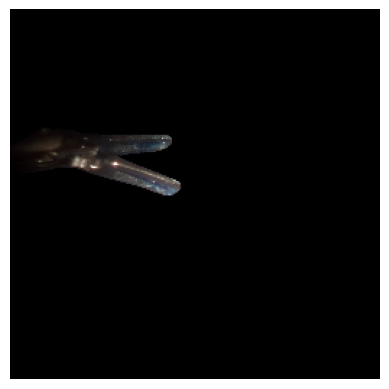

In [50]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/data/tissue_75/segment_results/"

# Count the number of files and prepare the image list
imgs = []
image_num = count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]

    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = pad_to_match_aspect(img, 1.0)
    
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

make_video(imgs, filename="mask_test")

IPImage(filename="mask_test.gif")
plt.imshow(imgs[30].permute(1,2,0).detach().cpu().numpy())
plt.axis('off')

In [51]:


def optimize_and_tune(
    example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
    world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=30,
    max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
):
    """
    Iteratively tunes num_iterations and learning rates to minimize errors.
    
    Args:
        example_camera: Camera object for rendering.
        gaussians: Gaussian object for rendering.
        background_color: Background color for rendering.
        imgs: List of reference images for optimization.
        loss_fn: Loss function.
        joint_pose_result: Initial joint pose parameter.
        world_view_transform_result: Initial world view transform parameter.
        ee_l_qpos: Ground truth trajectory (numpy array).
        initial_lr: Initial learning rate.
        initial_iterations: Initial number of iterations.
        max_epochs: Maximum number of tuning epochs.
        error_threshold: Error threshold for stopping.
        decay_factor: Factor to decay learning rate and iterations.
        lr_min: Minimum learning rate.

    Returns:
        Tuple of tuned parameters, errors, and final visualization.
    """
    best_errors = None
    best_config = None
    current_lr = initial_lr
    current_iterations = initial_iterations

    for epoch in range(max_epochs):
        print(f"Epoch {epoch + 1}/{max_epochs}")
        optimizer = torch.optim.Adam([
            {"params": joint_pose_result, "lr": current_lr},
            {"params": world_view_transform_result, "lr": current_lr}
        ])

        joint_pose_results = []
        world_view_transform_results = []
        results = []

        for img in imgs:
            video, joint_pose_result, world_view_transform_result = optimization_w2v(
                example_camera, gaussians, background_color, img, loss_fn, optimizer,
                joint_pose_result, world_view_transform_result, num_iterations=current_iterations
            )
            joint_pose_results.append(joint_pose_result.clone().detach())
            world_view_transform_results.append(world_view_transform_result.clone().detach())

        trans_init = world_view_transform_results[0][3, :3].detach().cpu().numpy()
        for r in world_view_transform_results:
            res = r[3, :3].detach().cpu().numpy()
            res = trans_init - res
            results.append(res)

        # Compute errors
        errors = []
        for i in range(len(ee_l_qpos)):
            error = np.linalg.norm(ee_l_qpos[i, :3] - results[i][:3])
            errors.append(error)
        
        mean_error = np.mean(errors)
        print(f"Mean error: {mean_error}")

        # Update best configuration if errors improve
        if best_errors is None or mean_error < np.mean(best_errors):
            best_errors = errors
            best_config = (current_lr, current_iterations)

        # Adjust learning rates and iterations if error is not improving significantly
        if mean_error < error_threshold:
            print("Error threshold reached. Stopping optimization.")
            break
        elif epoch > 0 and mean_error >= np.mean(best_errors):
            current_lr = max(current_lr * decay_factor, lr_min)
            current_iterations = int(current_iterations * (1 + decay_factor))
            print(f"Adjusting learning rate to {current_lr} and iterations to {current_iterations}.")

    # Final visualization
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for res in results:
        ax.scatter(res[0], res[1], res[2], c="b")
    ax.scatter(ee_l_qpos[:, 0], ee_l_qpos[:, 1], ee_l_qpos[:, 2], c="r")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(-90, 90)
    plt.title("Relative action trajectory")
    plt.show()

    plt.plot(best_errors, label="Best Errors")
    plt.xlabel("Frame")
    plt.ylabel("Error")
    plt.title("Error between the estimated and the ground truth")
    plt.legend()
    plt.show()

    return best_config, best_errors


In [52]:

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos = ee_l_qpos - ee_l_qpos_init

# best_config, best_errors = optimize_and_tune(
#     example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
#     world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=10,
#     max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
# )

In [53]:
# best_config

In [54]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []

# Optimization loop
num_iterations = 10
# Define different learning rates
# joint_pose_lr = 5e-4
# rotation_lr = 1
# translation_lr = 3e-5

joint_pose_lr = 8e-4
translation_lr = 5e-5
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": euler_angles, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
for img in imgs:
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result= optimization_w2v(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization_quat(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result.clone().detach())
    world_view_transform_results.append(world_view_transform_result.clone().detach())
    # euler_results.append(euler_result.clone().detach())
    # trans_results.append(trans_result.clone().detach())
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


In [55]:
joint_pose_results

[tensor([ 0.0500,  0.1923,  0.1477, -0.1173,  0.2245], device='cuda:0'),
 tensor([ 0.0516,  0.1928,  0.1474, -0.1149,  0.2241], device='cuda:0'),
 tensor([ 0.0529,  0.1941,  0.1461, -0.1129,  0.2235], device='cuda:0'),
 tensor([ 0.0543,  0.1945,  0.1459, -0.1112,  0.2227], device='cuda:0'),
 tensor([ 0.0557,  0.1934,  0.1474, -0.1090,  0.2222], device='cuda:0'),
 tensor([ 0.0601,  0.1881,  0.1529, -0.1082,  0.2214], device='cuda:0'),
 tensor([ 0.0593,  0.1902,  0.1508, -0.1066,  0.2219], device='cuda:0'),
 tensor([ 0.0674,  0.1829,  0.1579, -0.1113,  0.2166], device='cuda:0'),
 tensor([ 0.0693,  0.1797,  0.1610, -0.1074,  0.2200], device='cuda:0'),
 tensor([ 0.0744,  0.1759,  0.1645, -0.1099,  0.2171], device='cuda:0'),
 tensor([ 0.0819,  0.1702,  0.1699, -0.1141,  0.2125], device='cuda:0'),
 tensor([ 0.0869,  0.1674,  0.1720, -0.1148,  0.2115], device='cuda:0'),
 tensor([ 0.0922,  0.1640,  0.1745, -0.1142,  0.2116], device='cuda:0'),
 tensor([ 0.0987,  0.1596,  0.1779, -0.1138,  0.211

MoviePy - Building file tracking_sequence_test.gif with imageio.


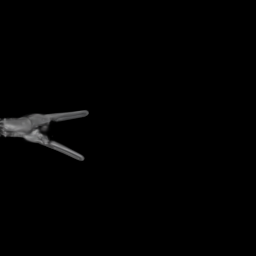

In [56]:
## ------ Save the video ------ ##
make_video(videos, "tracking_sequence_test")
IPImage(filename="tracking_sequence_test.gif")
# plt.figure()
# plt.imshow(videos[30].permute(1,2,0).detach().cpu().numpy())
# plt.axis('off')


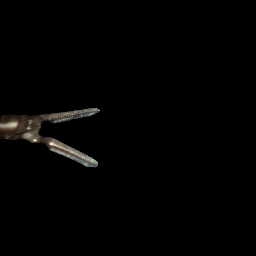

In [57]:
IPImage(filename="mask_test.gif")


In [58]:
trans_results = []
for w in world_view_transform_results:
    trans_results.append(w[3, :3].clone())
# trans_results = world_view_transform_results[:][:3, 3]

In [59]:
## plot the translation results
## 3D plot

print(joint_pose_result)


tensor([ 0.2250, -0.0112,  0.2490,  0.0607,  0.2463], device='cuda:0',
       requires_grad=True)


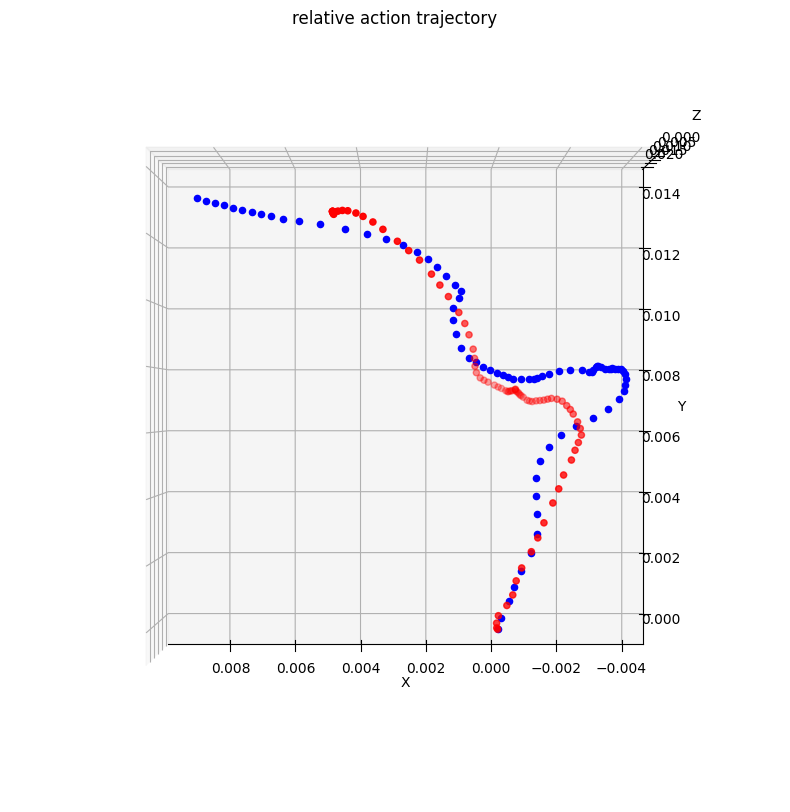

In [60]:
## read the csv file
ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
                        "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
                        "psm1_jaw"]

header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
                        "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
                        "psm2_jaw"]

ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
ee_l_qpos_init = ee_l_qpos[0]
## normalize the data (substract with the initial pose)
ee_l_qpos = ee_l_qpos - ee_l_qpos_init
results = []
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

trans_init = trans_results[8].detach().cpu().numpy()
count = 0
for r in trans_results:
    res = r.detach().cpu().numpy()
    res = trans_init - res
    results.append([res[0], res[1], -res[2]])
    if count >= 8:
        ax.scatter(res[0], res[1], -res[2], c="b")
    count += 1
    # if count>50: 
        # break
# # plt.show()
# ax = fig.add_subplot(121, projection='3d')
ax.scatter(ee_l_qpos[:, 0], ee_l_qpos[:, 1], ee_l_qpos[:, 2], c="r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
## look from the top
ax.view_init(-90, 90)
## set title
plt.title("relative action trajectory")
# ax.legend(["robot", "human"])
plt.show()

[0.00000000e+00 5.02799435e-05 1.95896546e-04 4.43264988e-04
 8.59444067e-04 1.25774633e-03 1.69316387e-03 2.12141008e-03
 2.68375537e-03 3.12973996e-03 3.60429593e-03 4.23805197e-03
 4.68650015e-03 5.10917023e-03 5.58282719e-03 5.88819814e-03
 6.15656855e-03 6.44895624e-03 6.68012482e-03 6.90752924e-03
 7.19105822e-03 7.38226662e-03 7.55419090e-03 7.78629472e-03
 7.92720270e-03 8.05306540e-03 8.14497927e-03 8.27746722e-03
 8.38080486e-03 8.46866390e-03 8.57958751e-03 8.67534571e-03
 8.75678971e-03 8.91147512e-03 9.01197540e-03 9.07661243e-03
 9.15311334e-03 9.19674317e-03 9.23465598e-03 9.27307639e-03
 9.30384964e-03 9.31899083e-03 9.30124117e-03 9.23508116e-03
 9.20840425e-03 9.20509976e-03 9.17636979e-03 9.15640781e-03
 9.14912419e-03 9.14972552e-03 9.14400243e-03 9.12804007e-03
 9.06405413e-03 8.98192216e-03 8.89894034e-03 8.81186688e-03
 8.79807058e-03 8.84628332e-03 8.95211381e-03 9.21161228e-03
 9.47067039e-03 9.76110781e-03 1.02447826e-02 1.06310291e-02
 1.10184879e-02 1.154328

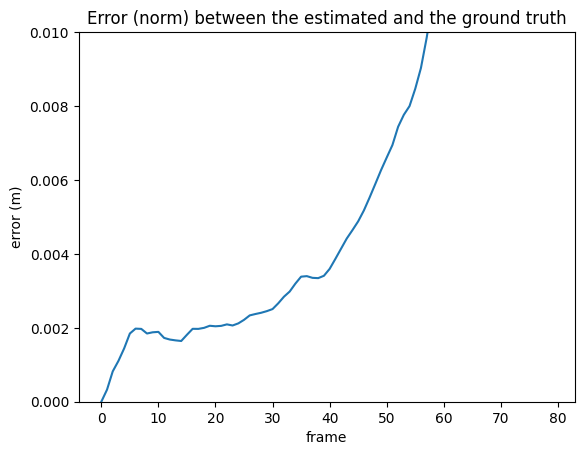

In [61]:
## plot error between the estimation and the ground truth
errors = []

n = 3
for i in range(len(ee_l_qpos)-8):
    error = np.linalg.norm(ee_l_qpos[i, :n] - results[i+8][:n])

    errors.append(error)

print(np.linalg.norm(ee_l_qpos[:, :n], axis=1))
plt.plot(errors)
# plt.plot(np.linalg.norm(ee_l_qpos[:, :n], axis=1), 'r')
plt.xlabel("frame")
plt.ylabel("error (m)")
plt.ylim(0, 0.01)
plt.title("Error (norm) between the estimated and the ground truth")
plt.show()

